In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# import classy 
import emcee
import corner
from classy import Class
from IPython.display import display, Math


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

### Constants of Utility

In [2]:
ombh2 = 0.022 # Planck2018
omch2 = 0.120 # Planck2018
h = 0.675
H0 = h*100 # 67.5 -- Planck2018
As=2e-9 
ns=0.96

### Testing to get Pk plot

In [64]:
test = Class() # create class

test.set({'omega_b':ombh2, 'omega_cdm':omch2, 'H0':H0, 'A_s':A_s, 'n_s':n_s}) # initial params

test.set({'output':'mPk', # 'mPk' for total matter power spectrum P(k) infered from gravitational potential
          'non_linear':'hmcode', # want halofit or HMCode??  
          'feedback model':'owls_agn', # (0.76, 2.32)   fits the OWLS simulation that includes AGN feedback
          'P_k_max_h/Mpc':10, # k_max [h/Mpc]
          'lensing':'no', # lensing 
          'z_pk':0, # redshift
         })
test.compute() # run class

In [65]:
ks = np.logspace(-5, 1, 1000) # k in h/Mpc
Pks = [] # P(k) in (Mpc/h)**3
h = test.h() # get reduced Hubble for conversions to 1/Mpc
for k in ks:
    Pk = test.pk(k*h, 0)*h**3 # function .pk(k,z)
    Pks.append(Pk) 

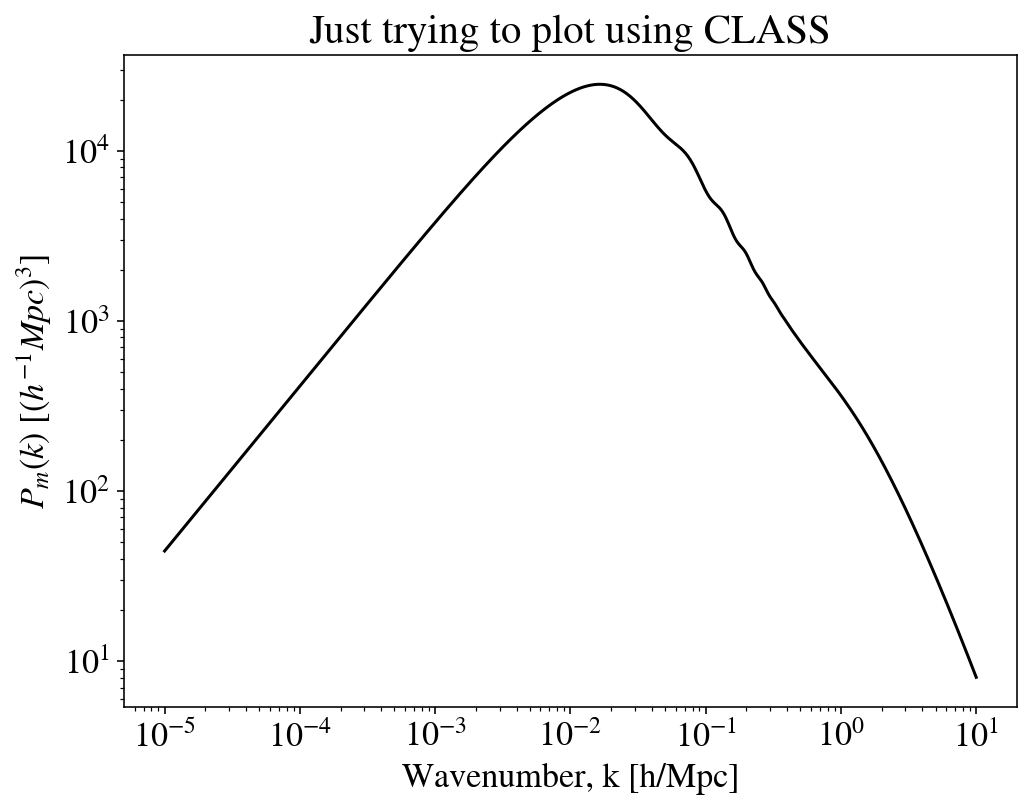

In [66]:
plt.figure(figsize=(8,6))
plt.loglog(ks, Pks, 'k')
plt.ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
plt.xlabel('Wavenumber, k [h/Mpc]')
plt.title('Just trying to plot using CLASS')
plt.show()

## Create "fake" observational data 

Using Planck2018 cosmo and arbitrarily setting the baryonic feedback params

In [3]:
data = Class() # create class -- Planck2018 cosmological params and baryonic feedback

data.set({'omega_b':ombh2, 'omega_cdm':omch2, 'H0':H0, 'A_s':As, 'n_s':ns}) # initial params

data.set({'output':'mPk',
          'non_linear':'hmcode', # non-linear using HMCode
          'eta_0':0.95, # setting baryon parameters arbitrarily 
          'c_min':4, # setting baryon parameters arbitrarily 
          'P_k_max_h/Mpc':10, # k_max [h/Mpc]
          'lensing':'no', 
          'z_pk':0, # redshift
          })

data.compute() # run class

In [4]:
ks_data = np.logspace(-5, 1, 1000) # k in h/Mpc

Pks_data = [] # P(k) in (Mpc/h)**3
h = data.h() # get reduced Hubble for conversions to 1/Mpc
for k in ks_data:
    Pk = data.pk(k*h, 0)*h**3 # function .pk(k,z)
    Pks_data.append(Pk) 
Pks_data = np.array(Pks_data)    

Pks_err = 0.10*Pks_data # creating error

## Log-Likelihood function

In [5]:
def log_likelihood(theta, x, y, yerr): 
    eta, c = theta
    
    model = Class()
    model.set({'omega_b':ombh2, 'omega_cdm':omch2, 'H0':H0, 'A_s':As, 'n_s':ns})
    model.set({'output':'mPk',
              'non_linear':'hmcode',
              'eta_0':eta, 
              'c_min':c, 
              'P_k_max_h/Mpc':10,
              'lensing':'no', 
              'z_pk':0,
              })
    model.compute()
    
    ks_model = np.logspace(-5, 1, 1000) # k in h/Mpc

    Pks_model = [] # P(k) in (Mpc/h)**3
    h = model.h() # get reduced Hubble for conversions to 1/Mpc
    for k in ks_data:
        Pk = model.pk(k*h, 0)*h**3
        Pks_model.append(Pk) 
    Pks_model = np.array(Pks_model) 
    
    sigma2 = yerr**2
    return -0.5 * np.sum((y - Pks_model)**2 / sigma2 + np.log(sigma2))

In [6]:
nll = lambda *args: -log_likelihood(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([0.76, 2.32]) # using defaults, which are off from truths
soln = minimize(nll, initial, args=(ks_data, Pks_data, Pks_err))
eta_ml, c_ml = soln.x # maximum likelihood values
print('Maximum likelihood values:', soln.x)

Maximum likelihood values: [0.94999999 3.99999995]


## MCMC

In [7]:
def log_prior(theta): # sets up priors on theta
    eta, c = theta
    if -5.0 < eta < 6 and -5.0 < c < 10:
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta) 
    if not np.isfinite(lp): 
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [9]:
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(ks_data, Pks_data, Pks_err))


sampler.run_mcmc(pos, 50, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [20:54<00:00, 25.09s/it]


In [10]:
samples = sampler.get_chain()
np.save('Data/50_sample_test.npy', samples)

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.33867928 4.73119626]

## Plotting and Analyzing

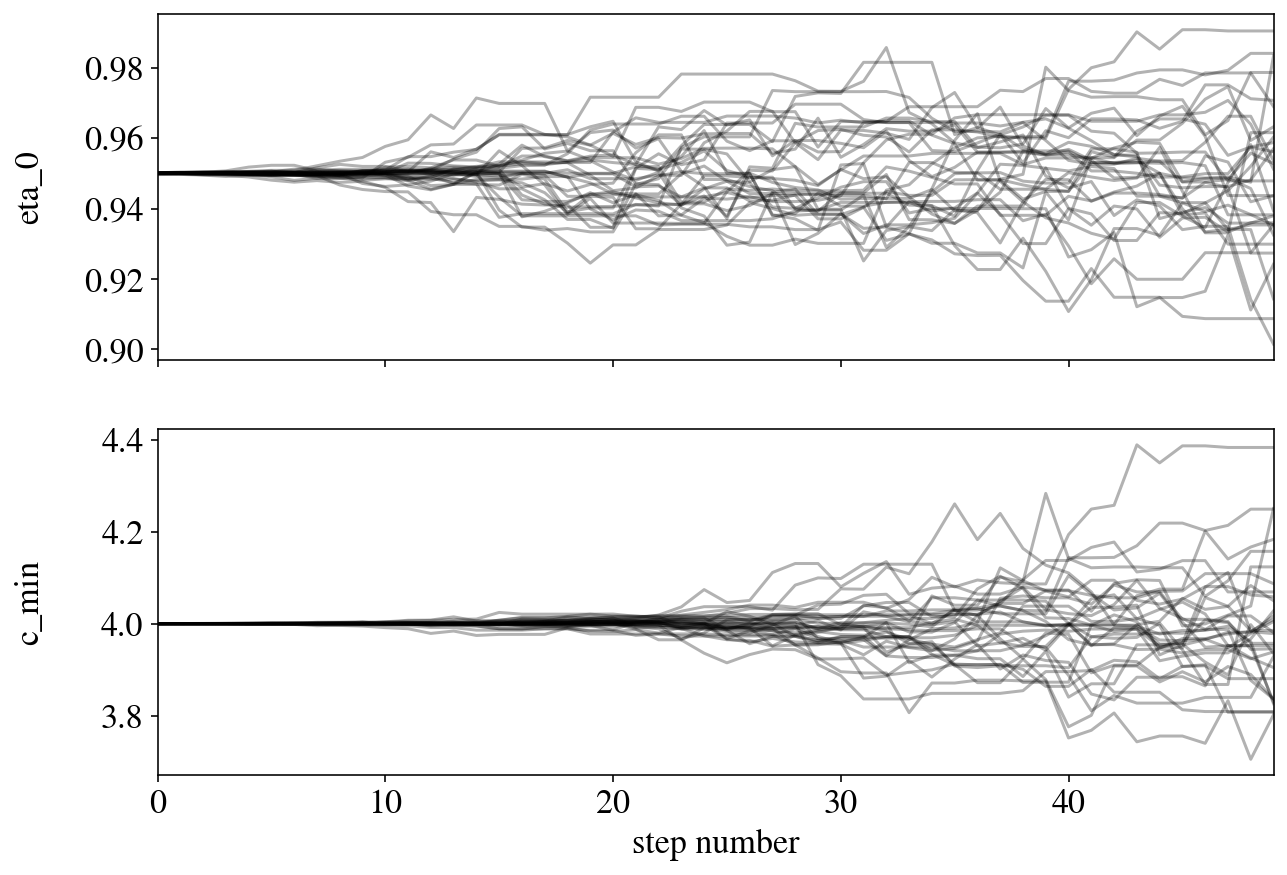

In [11]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ['eta_0', 'c_min']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

(384, 2)


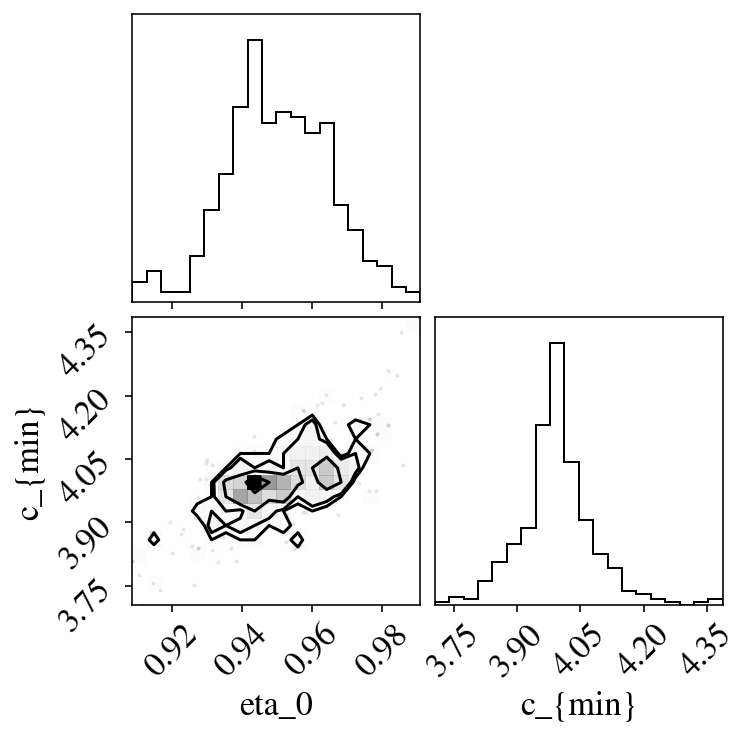

In [25]:
flat_samples = sampler.get_chain(discard=25, thin=2, flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=initial);

In [22]:
labels = ['eta_0', 'c_{min}']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>